<br>

## Contexte (HumanForYou) et objectif

HumanForYou (pharmaceutique, ~4000 employés) observe un taux de rotation annuel d’environ **15%**.
L’entreprise souhaite :
1) **identifier les facteurs** qui influencent l’attrition,
2) **prédire** la probabilité qu’un employé quitte l’entreprise (Attrition),
3) proposer des **pistes d’amélioration** pour motiver la rétention.

Nous disposons de variables RH (profil, poste, salaire…), d’évaluations manager, d’un sondage QVT, et de données badgeuse (entrées/sorties) sur 2015.
La cible `Attrition` indique si l’employé a quitté l’entreprise durant **2016**.

<br>

### Sommaire

1. Contexte et objectif  

2. Préparation de l’environnement  

3. Données  

4. Feature Engineering (données badgeuse)  

5. Génération du dataset final  

6. Gestion des valeurs manquantes  

7. Analyse Exploratoire (EDA)  

8. Préprocessing / Encodage (Pipeline)  

9. Screening rapide : LazyPredict (optionnel)  

10. Modèles candidats (Model Building)  

11. Comparaison des modèles (Cross-Validation)  

12. Modèle final et évaluation sur test  

13. Conclusion et recommandations RH  

<br>

## Imports et utilitaires (1 seule cellule)

In [69]:
# --- 0) SETUP ---

import os, glob, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


from sklearn.metrics import (
    make_scorer, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)

# XGBoost (optionnel)
try:
    from xgboost import XGBClassifier
    XGBOOST_OK = True
except Exception:
    XGBOOST_OK = False
    print("xgboost non installé -> XGBoost ignoré (pip install xgboost).")

# Utilitaire: densifier uniquement si nécessaire
def to_dense(X):
    return X.toarray() if sparse.issparse(X) else X

densify = FunctionTransformer(to_dense, accept_sparse=True)


## 2) Données

### Chargement des fichiers
On charge l’ensemble des fichiers CSV présents dans un dossier local, puis on stocke chaque dataset dans un dictionnaire `dfs`.


In [70]:

#import files
base_path = r"C:\Users\ldxd1\Downloads\projet AI"

# Dictionnaire pour stocker tous les DataFrames
dfs = {}

for file_path in glob.glob(os.path.join(base_path, "*.csv")):
    file_name = os.path.basename(file_path)   # ex : 'employee_survey_data.csv'
    key = os.path.splitext(file_name)[0]      # ex : 'employee_survey_data'
    
    dfs[key] = pd.read_csv(file_path)
    print(f"Chargé : {file_name} → dfs['{key}']")


Chargé : employee_survey_data.csv → dfs['employee_survey_data']
Chargé : general_data.csv → dfs['general_data']
Chargé : in_time.csv → dfs['in_time']
Chargé : manager_survey_data.csv → dfs['manager_survey_data']
Chargé : out_time.csv → dfs['out_time']


## 3) Compréhension des données

On inspecte les types, la présence de valeurs manquantes, et la structure des datasets (surveys, general data, badgeuse).


In [71]:

for name in ["employee_survey_data", "manager_survey_data", "general_data", "in_time", "out_time"]:
    print(f"\n{name} :\n")
    dfs[name].info()



employee_survey_data :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 137.9 KB

manager_survey_data :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   EmployeeID         4410 non-null   int64
 1   JobInvolvement     4410 non-null   int64
 2   PerformanceRating  4410 non-null   int64
dtypes: int64(3)
memory usage: 103.5 KB

general_data :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Da

## 4) Feature engineering badgeuse

Les datasets `in_time` et `out_time` permettent d’estimer un temps moyen de travail par employé en 2015.

Principe :
- convertir les heures d’entrée et sortie en datetime,
- calculer `dur = out_dt - in_dt` par jour,
- prendre la moyenne par employé (en heures).


Les datasets contiennent tous les détails des sondages sur les employés, les manager et les heures d'entrées et de sorties de tous les effectifs en 2015.

Pour dossier "in_time" et "out_time" il nous permet d'avoir le temps moyen de travail pour chaque employé, les autres informations ne nous sont pas utiles.


In [72]:
# General Data (optionnel car fichier trop volumineux)

in_df  = dfs["in_time"]
out_df = dfs["out_time"]

emp_col = in_df.columns[0]  # "Unnamed: 0"

in_w  = in_df.set_index(emp_col)
out_w = out_df.set_index(emp_col)

common_cols = in_w.columns.intersection(out_w.columns)

in_dt  = in_w[common_cols].apply(pd.to_datetime, errors="coerce")
out_dt = out_w[common_cols].apply(pd.to_datetime, errors="coerce")

dur = out_dt - in_dt  # Timedelta par employé et par jour

mean_dur  = dur.mean(axis=1, skipna=True)
mean_hours = mean_dur.dt.total_seconds() / 3600

result = pd.DataFrame({
    "employee_id": mean_dur.index.astype(int),
    "mean_hours": mean_hours
})
print(result)


nb_emp_total = result["employee_id"].nunique()
nb_emp_sous_8h = (result["mean_hours"] < 8).sum()

print(f"Il y a {nb_emp_sous_8h} d'employés qui travaillent moins de 8h sur {nb_emp_total} employés total")

# Nous voyons clairement qu'il y a un manque d'assiduité dans les effectifs   
# Summary statistics
for name in ["employee_survey_data", "manager_survey_data", "general_data"]:
    print(f"\n{name} :\n")
    print(dfs[name].describe())


            employee_id  mean_hours
Unnamed: 0                         
1                     1    7.373651
2                     2    7.718969
3                     3    7.013240
4                     4    7.193678
5                     5    8.006175
...                 ...         ...
4406               4406    8.522277
4407               4407    6.092954
4408               4408    7.706632
4409               4409    9.492595
4410               4410    6.988948

[4410 rows x 2 columns]
Il y a 3087 d'employés qui travaillent moins de 8h sur 4410 employés total

employee_survey_data :

        EmployeeID  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
count  4410.000000              4385.000000      4390.000000      4372.000000
mean   2205.500000                 2.723603         2.728246         2.761436
std    1273.201673                 1.092756         1.101253         0.706245
min       1.000000                 1.000000         1.000000         1.000000
25%    1103.25000

### Valeurs manquantes

On visualise les valeurs manquantes puis on applique une imputation :
- médiane pour les variables numériques,
- mode pour les variables catégorielles.


Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
mean_time                   0
dtype: int64


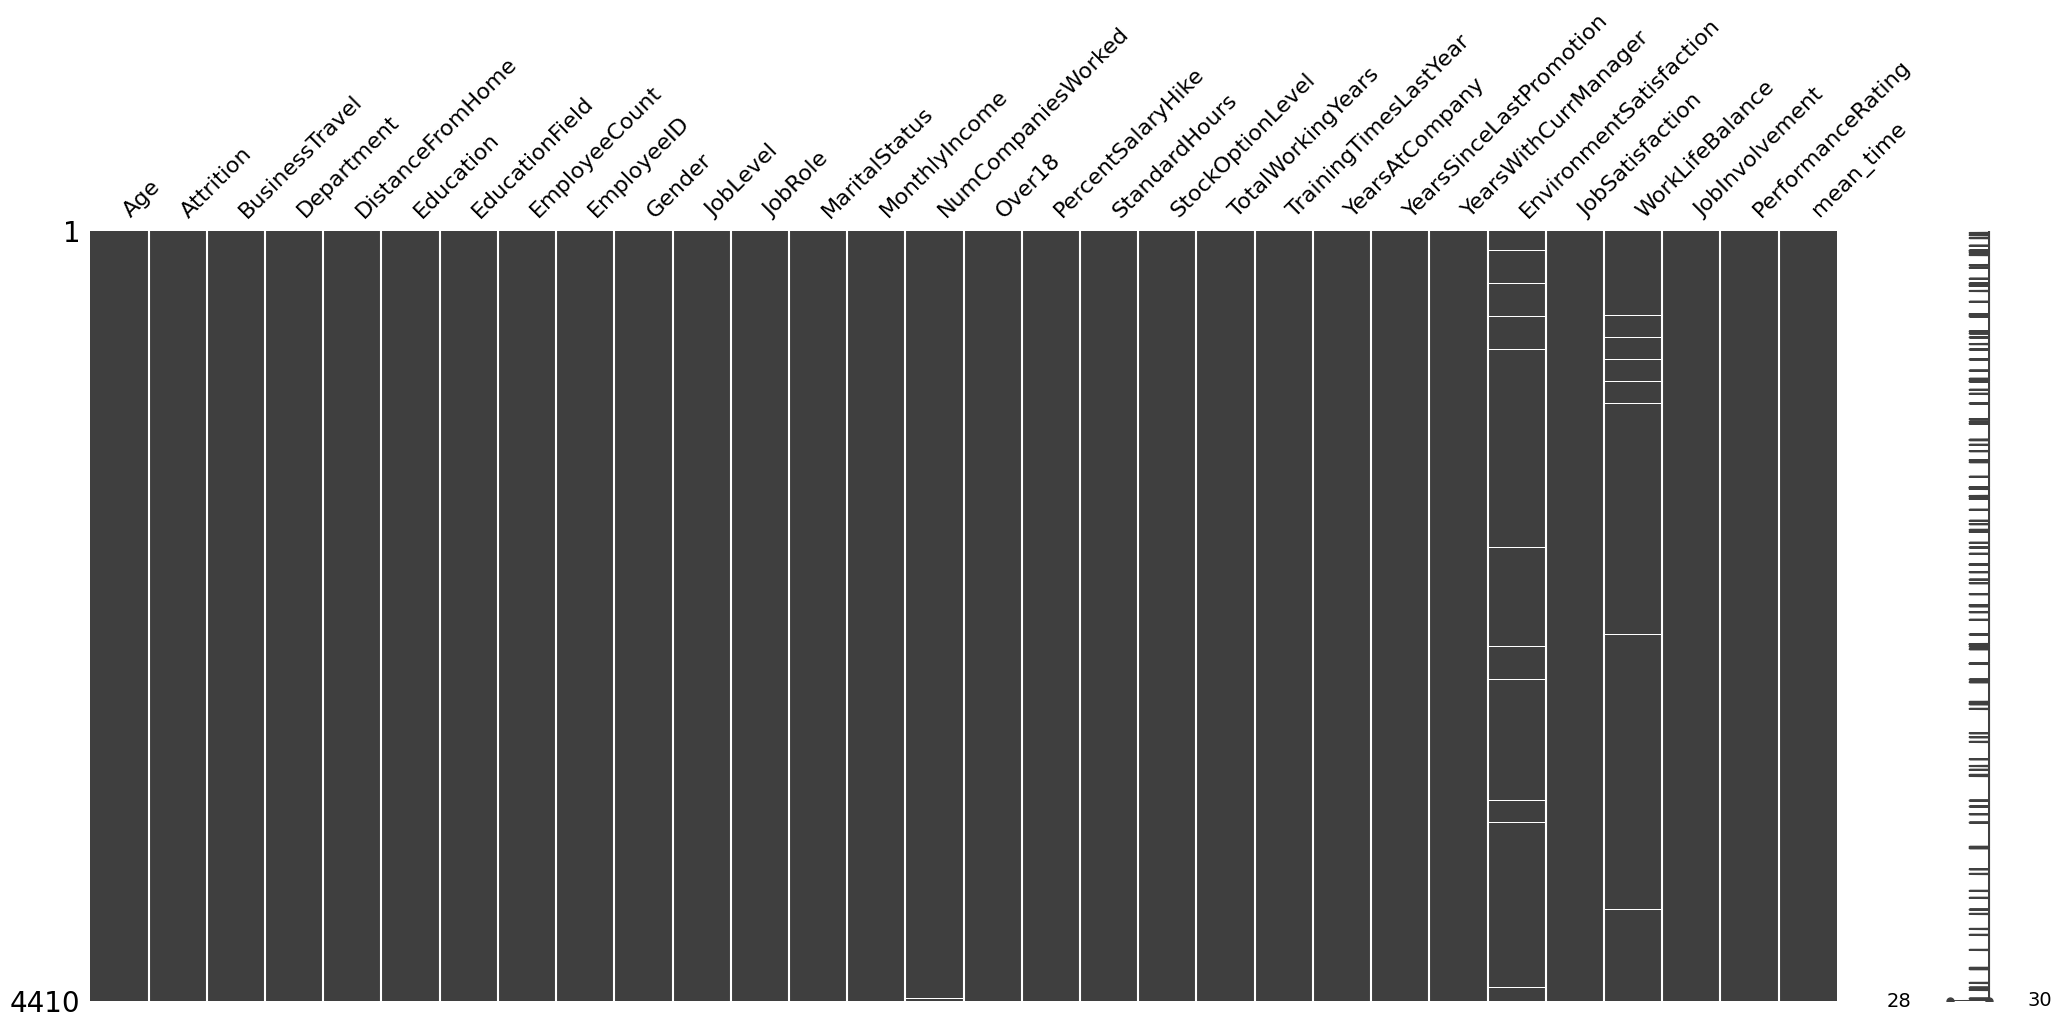

after the filling
numerical_columns :  Index(['Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
       'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'JobInvolvement', 'PerformanceRating', 'mean_time'],
      dtype='object')
categorical columns :  Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18'],
      dtype='object')


In [73]:

# show missing values
print(df.isnull().sum())

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize missing data
msno.matrix(df)
plt.show()

# Impute missing values
# For numerical columns, use median imputation
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns] = df[numerical_columns].fillna(df[numerical_columns].median())

# For categorical columns, use mode imputation
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

print("after the filling")
# Verify that there are no more missing values
df.isnull().sum()

import seaborn as sns
import matplotlib.pyplot as plt

# Identify numerical and categorical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns
print('numerical_columns : ', numerical_columns)
print('categorical columns : ', categorical_columns)


## 5) Fusion et dataset final

On fusionne :
- `general_data` (base principale),
- `employee_survey_data`,
- `manager_survey_data`,
puis on ajoute la feature badgeuse `mean_time`.


In [74]:
# Fusion des Datasets
general_data      = dfs["general_data"]
employee_survey   = dfs["employee_survey_data"]
manager_survey    = dfs["manager_survey_data"]

df = None  # dataset final

if general_data is not None:
    # Standardiser la clé de jointure
    if "EmployeeId" in general_data.columns:
        general_data = general_data.rename(columns={"EmployeeId": "EmployeeID"})
    
    df = general_data.copy()
    
    if employee_survey is not None:
        df = df.merge(employee_survey, on="EmployeeID", how="left")
        print("Fusionné avec employee_survey_data")
    
    if manager_survey is not None:
        df = df.merge(manager_survey, on="EmployeeID", how="left")
        print("Fusionné avec manager_survey_data")
    
    print(f"\nDataset fusionné: {df.shape[0]} lignes × {df.shape[1]} colonnes")

    # AJOUT ICI : intégrer la variable mean_time calculée depuis in_time/out_time
    # (result doit déjà exister : colonnes ["employee_id", "mean_hours"])
    result_merge = result.rename(columns={"employee_id": "EmployeeID", "mean_hours": "mean_time"})
    df = df.merge(result_merge, on="EmployeeID", how="left")
    print("mean_time ajouté. Nb NaN mean_time =", df["mean_time"].isna().sum())

else:
    # Cas où on n'a pas general_data : on fusionne juste les surveys si possibles
    if (employee_survey is not None) and (manager_survey is not None):
        df = employee_survey.merge(manager_survey, on="EmployeeID", how="outer")
        print(f"\n Dataset partiel (surveys uniquement): {df.shape[0]} lignes × {df.shape[1]} colonnes")
        print("Sans general_data, la variable cible (Attrition) risque de manquer.")

        # AJOUT AUSSI ici (si tu veux mean_time même sans general_data)
        result_merge = result.rename(columns={"employee_id": "EmployeeID", "mean_hours": "mean_time"})
        df = df.merge(result_merge, on="EmployeeID", how="left")
        print("mean_time ajouté. Nb NaN mean_time =", df["mean_time"].isna().sum())

    else:
        print("Impossible de créer un dataset fusionné (données insuffisantes).")

print(df.info())


Fusionné avec employee_survey_data
Fusionné avec manager_survey_data

Dataset fusionné: 4410 lignes × 29 colonnes
mean_time ajouté. Nb NaN mean_time = 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non

### 6) Analyse exploratoire (EDA)

Objectifs :
- visualiser la distribution de l’attrition,
- identifier des variables associées au départ,
- produire des insights actionnables RH.


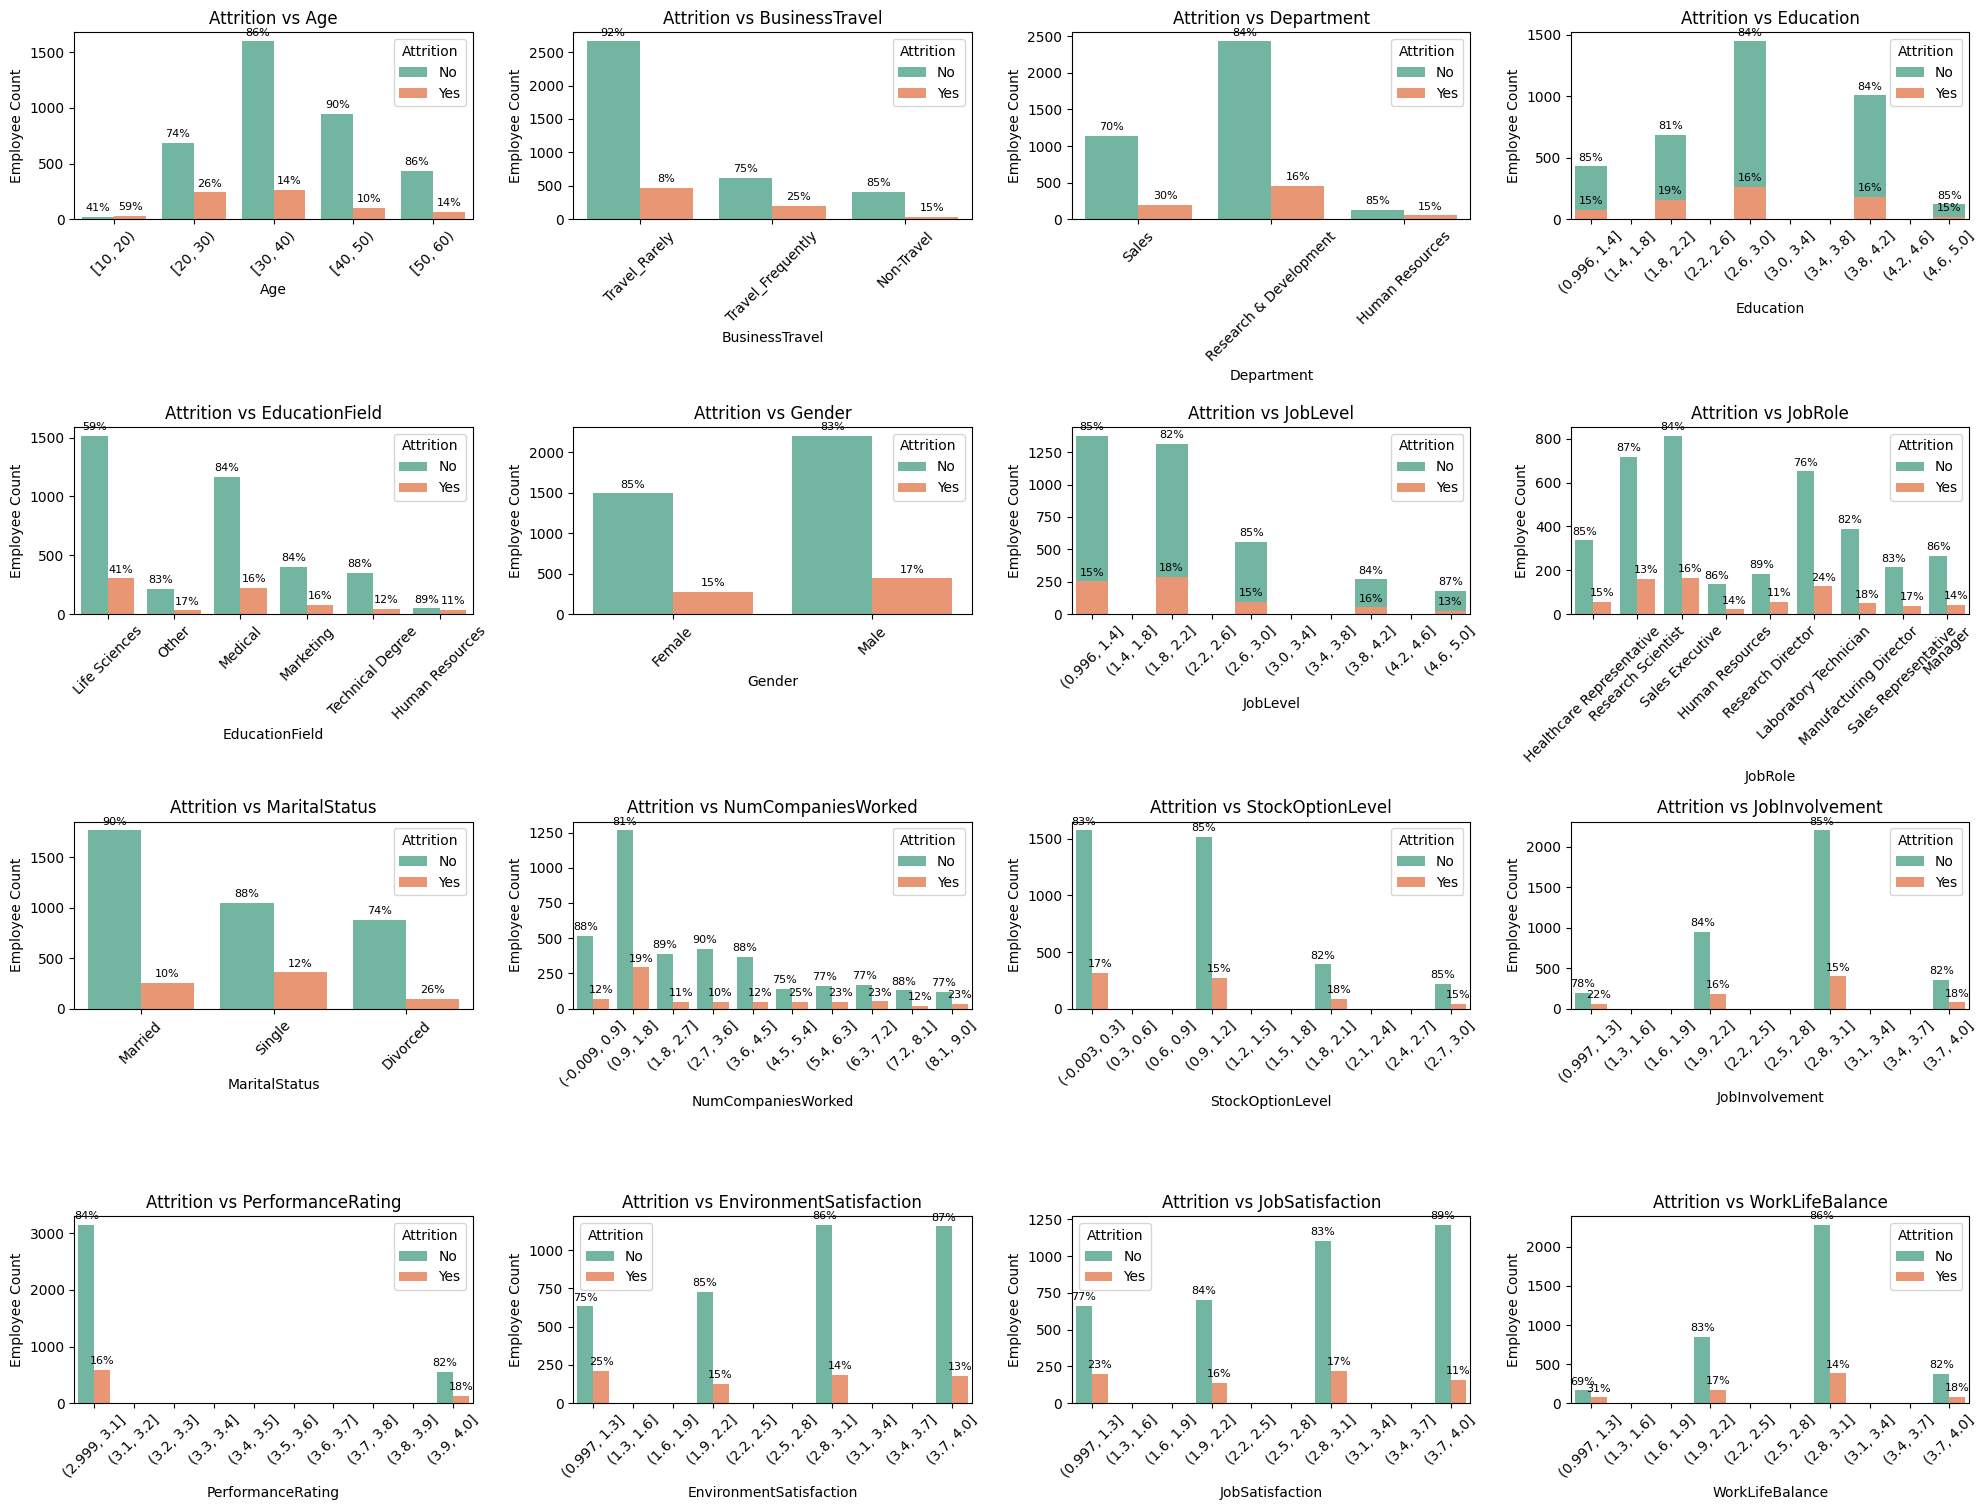

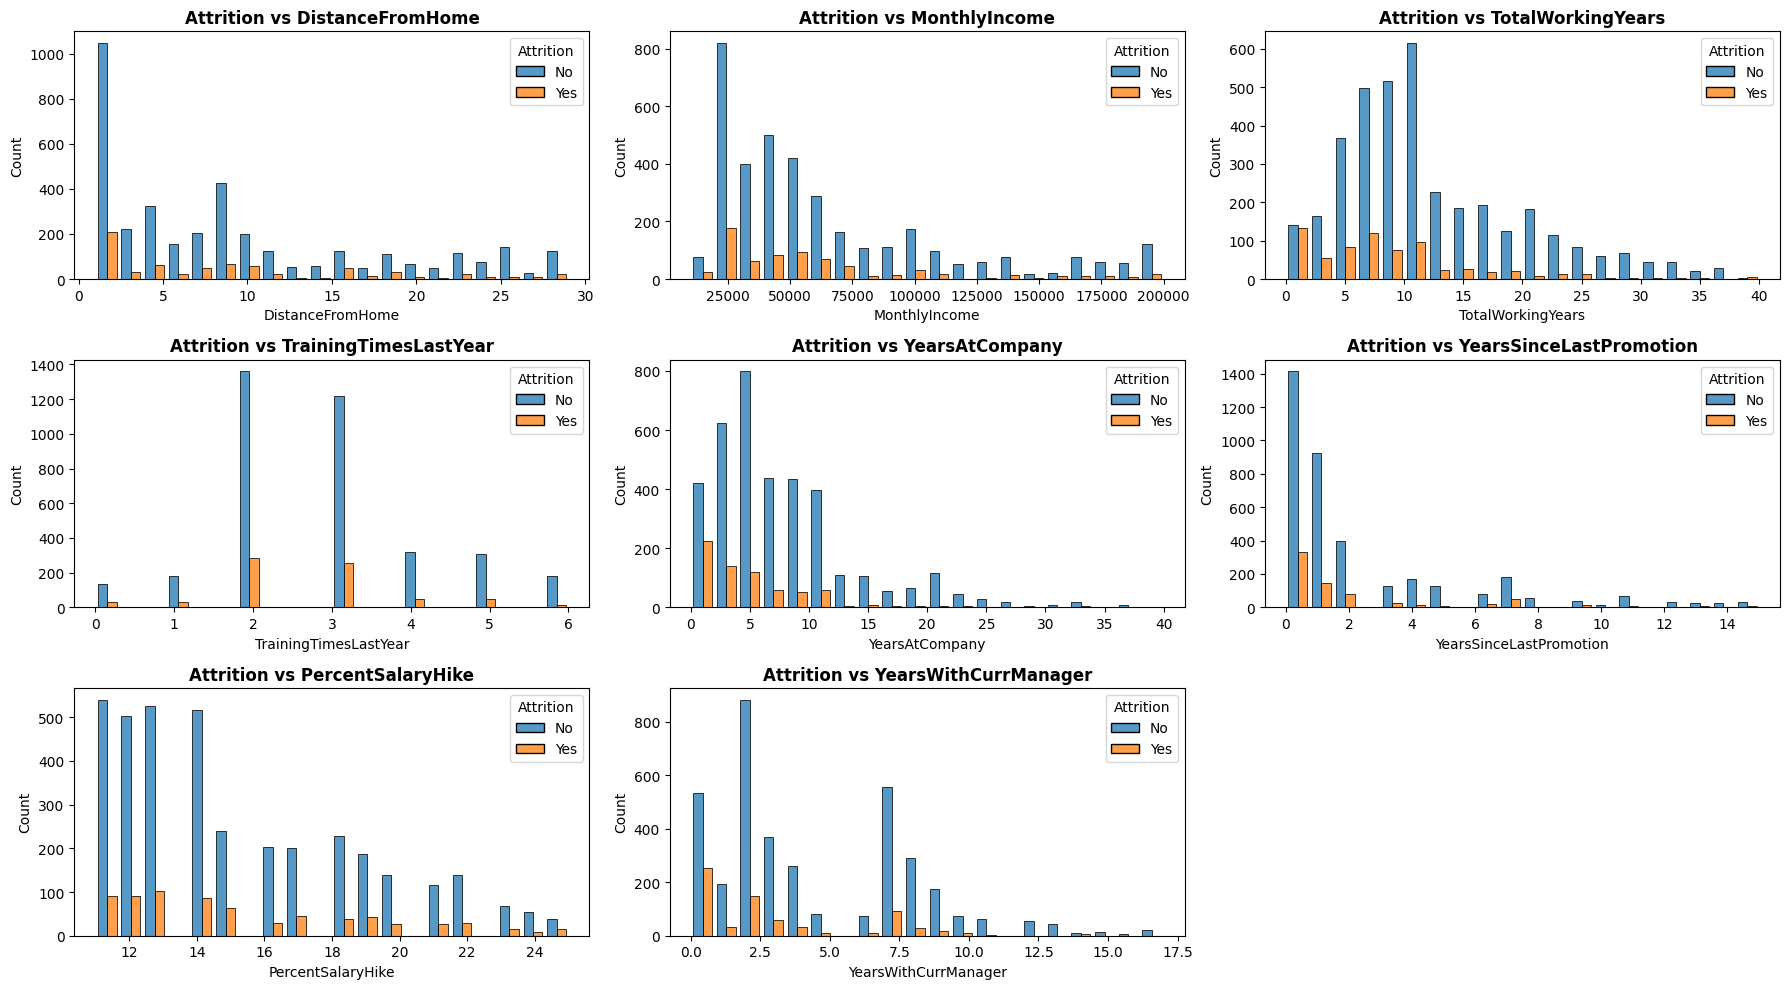

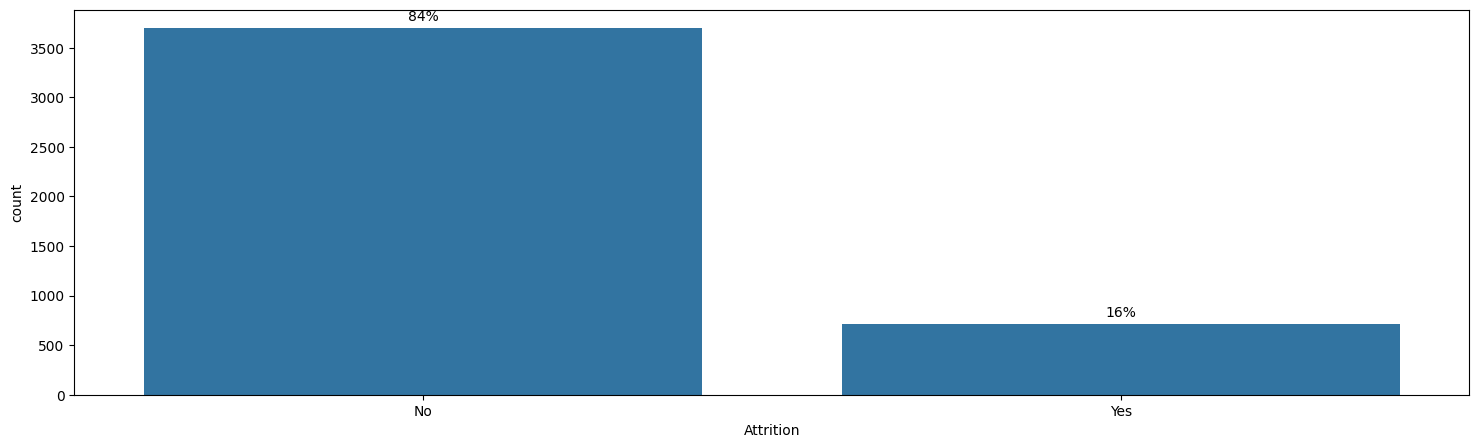

In [75]:
# Exploratory Data Analysis
# put remaining continuous features in a list
continuous_features = ['DistanceFromHome','MonthlyIncome','TotalWorkingYears','TrainingTimesLastYear', 'YearsAtCompany',
'YearsSinceLastPromotion','PercentSalaryHike','YearsWithCurrManager','mean_time']



df_eda = df.copy()
df_eda["Age"] = pd.cut(df_eda["Age"], range(10, 70, 10), right=False)

def add_percent_labels(ax, ct, fontsize=8):
    # ct: index = catégories/bins, colonnes = ["No","Yes"]
    containers = ax.containers
    if len(containers) < 2:
        return

    y_max = ax.get_ylim()[1]
    offset = 0.02 * y_max if y_max > 0 else 1

    for i, cat in enumerate(ct.index):
        total = ct.loc[cat].sum()
        if total == 0:
            continue

        for j, hue in enumerate(ct.columns):  # ["No","Yes"]
            bar = containers[j].patches[i]
            pct = ct.loc[cat, hue] / total
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + offset,
                f"{pct:.0%}",
                ha="center",
                va="bottom",
                fontsize=fontsize
            )

def make_plot(col, order=None, ax=None, bins=10, palette="Set2"):
    ax = ax or plt.gca()
    s = df_eda[col]

    # NUMERIQUE on le transforme en bins (histogramme en catégories) 
    if pd.api.types.is_numeric_dtype(s):
        binned = pd.cut(s, bins=bins)
        tmp = df_eda.copy()
        tmp["_binned_"] = binned

        sns.countplot(
            x="_binned_", hue="Attrition", data=tmp,
            hue_order=["No", "Yes"],
            ax=ax, palette=palette
        )

        ct = pd.crosstab(tmp["_binned_"], tmp["Attrition"]).reindex(columns=["No","Yes"], fill_value=0)
        add_percent_labels(ax, ct)

        ax.set_xlabel(col)
        ax.tick_params(axis="x", rotation=45)

    # CATEGORIEL
    else:
        sns.countplot(
            x=col, hue="Attrition", data=df_eda,
            order=order, hue_order=["No", "Yes"],
            ax=ax, palette=palette
        )

        ct = pd.crosstab(df_eda[col], df_eda["Attrition"]).reindex(columns=["No","Yes"], fill_value=0)
        if order is not None:
            ct = ct.reindex(order).dropna(how="all")

        add_percent_labels(ax, ct)
        ax.tick_params(axis="x", rotation=45)

    ax.set_title(f"Attrition vs {col}")
    ax.set_ylabel("Employee Count")
    ax.legend(title="Attrition")

# Matrice 
cols = [
    "Age","BusinessTravel","Department","Education","EducationField","Gender",
    "JobLevel","JobRole","MaritalStatus","NumCompaniesWorked","StockOptionLevel",
    "JobInvolvement","PerformanceRating","EnvironmentSatisfaction",
    "JobSatisfaction","WorkLifeBalance"
]

orders = {
    "Education": ["Below College","College","Bachelor","Master","Doctor"],
    "JobInvolvement": ["Low","Medium","High","Very High"],
    "EnvironmentSatisfaction": ["Low","Medium","High","Very High"],
    "JobSatisfaction": ["Low","Medium","High","Very High"],
    "WorkLifeBalance": ["Bad","Good","Better","Best"]
}

n_cols = 4
n_rows = (len(cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 3.8*n_rows))
axes = axes.ravel()

for ax, col in zip(axes, cols):
    make_plot(col, orders.get(col), ax=ax, bins=10)

for ax in axes[len(cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# put remaining continuous features in a list (SANS mean_time)
continuous_features = [
    'DistanceFromHome','MonthlyIncome','TotalWorkingYears',
    'TrainingTimesLastYear','YearsAtCompany','YearsSinceLastPromotion',
    'PercentSalaryHike','YearsWithCurrManager'
]

# 8 features → on garde une grille 3x3 et on masque la dernière case
fig, ax = plt.subplots(3, 3, figsize=(18, 10))

index = 0
for i in range(3):
    for j in range(3):

        # si on a déjà tracé toutes les features, on cache le subplot
        if index >= len(continuous_features):
            ax[i][j].set_visible(False)
            continue

        feat = continuous_features[index]
        ax[i][j].set_title(f'Attrition vs {feat}', fontsize=12, fontweight='bold')

        # histogrammes en colonnes, barres côte à côte pour Yes / No
        sns.histplot(
            data=df_eda,
            x=feat,
            hue='Attrition',
            multiple='dodge',
            bins=20,        # à ajuster si tu veux
            shrink=0.8,
            ax=ax[i][j]
        )

        ax[i][j].set_xlabel(feat)
        ax[i][j].set_ylabel('Count')
     
        index += 1

plt.tight_layout()
plt.show()

plt.figure(figsize=(18,5))

ax = sns.countplot(x="Attrition", data=df_eda, order=["No","Yes"])  # optionnel: ordre

total = sum(p.get_height() for p in ax.patches)

for p in ax.patches:
    h = p.get_height()
    ax.text(
        p.get_x() + p.get_width()/2,
        h + 0.01*total,                 # petit offset automatique
        f"{h/total:.0%}",
        ha="center",
        va="bottom"
    )

plt.show()



### Insights EDA (résumé)

- overall 16% employee attrition was observed during the year 2015.
- Employees in Human resources are highly prone to quit with an attrition rate of 30%
- similarly employees with human resources education background had an attrition rate of 41%
- 31% of the employees who quit had bad work life balance.
- young and unmarried employees are higly prone to quit with an average attrition rate of 24.5%.
- Employees who traveled frequently were also highly prone to quit with an attrition rate of 25%.
- employees at the lower job levels quit more often than employees on the higher level.
- employees in the research department (research directors and research scientists ) are also prone to quit with an average attrition rate of 21%.
- employees who have worked in more than 4 companies show a much higher attrition rate comapred to rest.
- attrition decreases with increasing environmental satisfaction, job satisfaction and job involvement.
- employee who leave company, worked for longer period of time, it means they could have been in higher work load or were not able to settle in company well.


## 7) Mise en place du modèle



In [76]:
#  PREP MODELING

df_model = df.copy()

# y binaire (Attrition Yes/No)
y = (df_model["Attrition"].astype(str).str.strip().str.lower() == "yes").astype(int)
X = df_model.drop(columns=["Attrition"]).copy()

# (Optionnel) conversions simples si tu les avais déjà
# Exemple : Gender Male/Female -> 1/0
if "Gender" in X.columns:
    X["Gender"] = (X["Gender"].astype(str).str.strip().str.lower() == "male").astype(int)

# Colonnes Y/N -> 0/1 si tu en as
for c in X.columns:
    if X[c].dtype == "object":
        vals = set(X[c].dropna().astype(str).str.strip().str.upper().unique())
        if vals.issubset({"Y", "N"}):
            X[c] = (X[c].astype(str).str.strip().str.upper() == "Y").astype(int)

# Drop ID si présent
for id_col in ["EmployeeID", "EmployeeNumber", "ID"]:
    if id_col in X.columns:
        X = X.drop(columns=[id_col])

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

def make_pipe(model_name, model):
    # RandomForest -> densifier après preprocess, sinon laisser en sparse
    if model_name == "RandomForest":
        return Pipeline(steps=[
            ("prep", preprocess),
            ("densify", densify),
            ("model", model)
        ])
    else:
        return Pipeline(steps=[
            ("prep", preprocess),
            ("model", model)
        ])


## 8) Modèles testés

In [77]:
# MODELS

models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=400, class_weight="balanced", n_jobs=-1, random_state=42
    ),
    "LogReg": LogisticRegression(
        max_iter=3000, class_weight="balanced", n_jobs=-1, random_state=42
    ),
    "SVM": LinearSVC(
        class_weight="balanced", random_state=42
    )
}

if XGBOOST_OK:
    models["XGBoost"] = XGBClassifier(
        n_estimators=600, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, random_state=42, n_jobs=-1,
        eval_metric="logloss"
    )

model_order = ["RandomForest", "XGBoost", "LogReg", "SVM"]
selected_models = {k: models[k] for k in model_order if k in models}


## 9) Comparaison des modèles

## 10) Choix du modèle final

### 10.1  helper score (proba/decision_function)

In [78]:
def oof_scores(pipe, base_model, X_tr, y_tr, cv):
    if hasattr(base_model, "predict_proba"):
        return cross_val_predict(pipe, X_tr, y_tr, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]
    if hasattr(base_model, "decision_function"):
        return cross_val_predict(pipe, X_tr, y_tr, cv=cv, method="decision_function", n_jobs=-1)
    return cross_val_predict(pipe, X_tr, y_tr, cv=cv, method="predict", n_jobs=-1).astype(float)


### 10.2  Courbes PR + ROC sur un même dataset (OOF train)

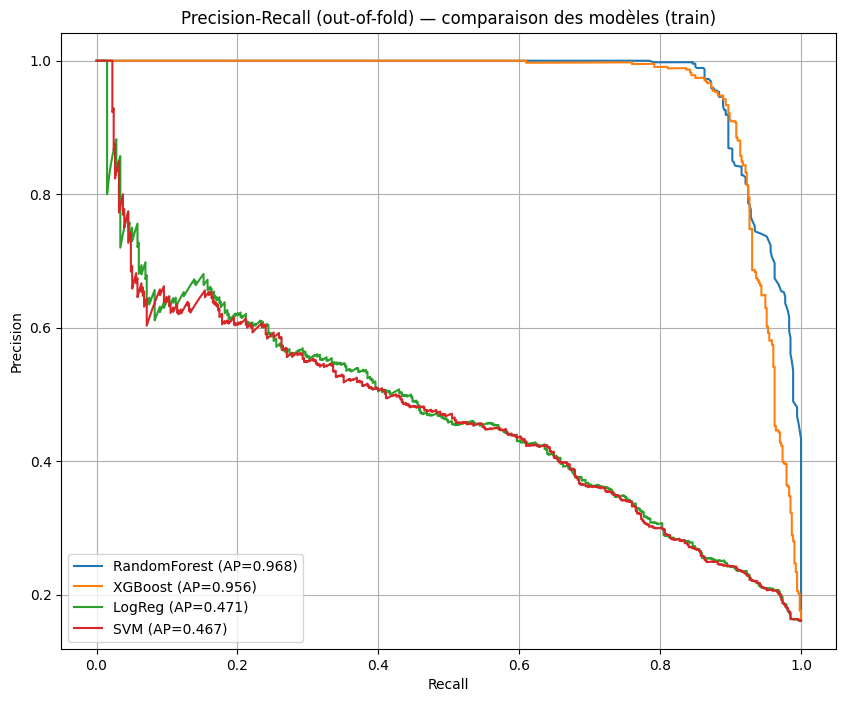

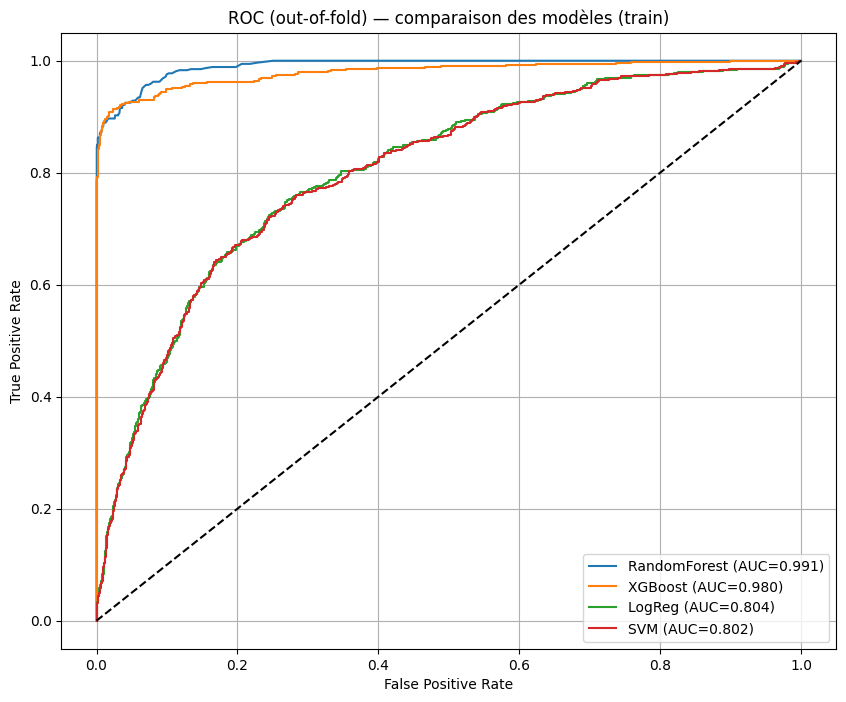

In [79]:
cv_curves = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# PR Curve
plt.figure(figsize=(10, 8))
for name, model in selected_models.items():
    pipe = make_pipe(name, model)
    y_score = oof_scores(pipe, model, X_train, y_train, cv_curves)

    precision, recall, _ = precision_recall_curve(y_train, y_score)
    ap = average_precision_score(y_train, y_score)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (out-of-fold) — comparaison des modèles (train)")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve
plt.figure(figsize=(10, 8))
for name, model in selected_models.items():
    pipe = make_pipe(name, model)
    y_score = oof_scores(pipe, model, X_train, y_train, cv_curves)

    fpr, tpr, _ = roc_curve(y_train, y_score)
    auc_roc = roc_auc_score(y_train, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_roc:.3f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (out-of-fold) — comparaison des modèles (train)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### 10.3  Matrices de confusion pour les 4 modèles (OOF train) + couleurs ≠ bleu/blanc

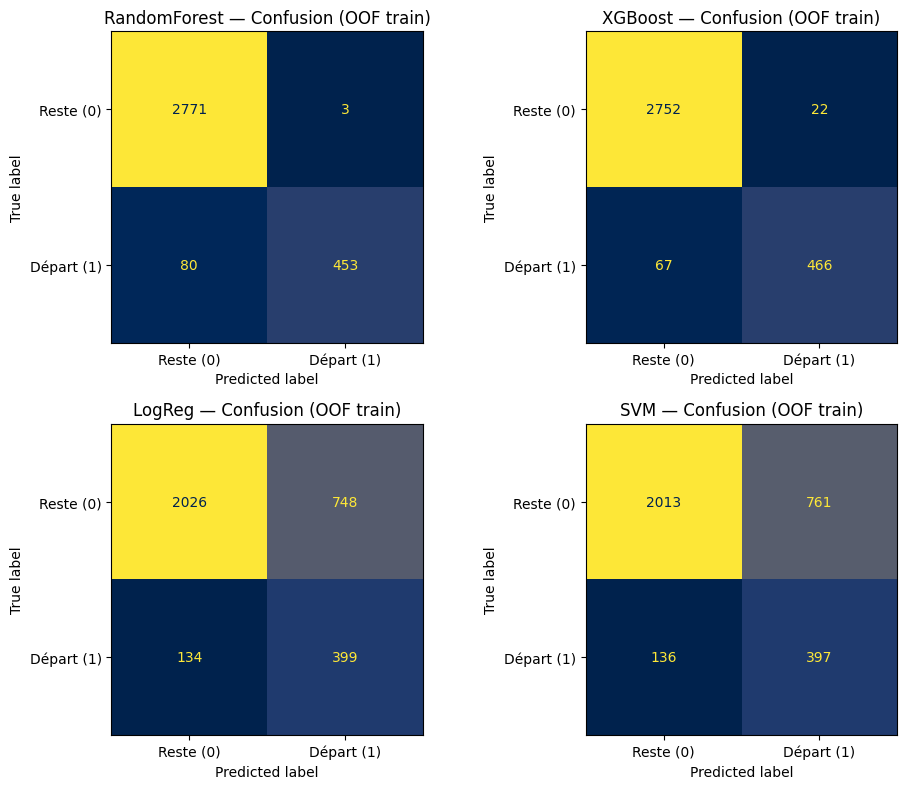

In [80]:
cv_cm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
CMAP = "cividis"  # change si tu veux: "viridis", "Greens", "Purples", ...

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for i, (name, model) in enumerate(selected_models.items()):
    pipe = make_pipe(name, model)
    y_pred_oof = cross_val_predict(pipe, X_train, y_train, cv=cv_cm, method="predict", n_jobs=-1)

    cm = confusion_matrix(y_train, y_pred_oof, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["Reste (0)", "Départ (1)"])
    disp.plot(ax=axes[i], cmap=CMAP, colorbar=False, values_format="d")
    axes[i].set_title(f"{name} — Confusion (OOF train)")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### 10.4 Cross-validation (tableau) + choix du meilleur modèle (tri F1)

In [81]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "f1": make_scorer(f1_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "recall": make_scorer(recall_score, zero_division=0),
}

cv_results = []

for name, model in selected_models.items():
    pipe = make_pipe(name, model)
    scores = cross_validate(
        pipe, X_train, y_train,
        cv=cv, scoring=scoring,
        n_jobs=-1, return_train_score=False
    )

    cv_results.append({
        "model": name,
        "cv_accuracy_mean": scores["test_accuracy"].mean(),
        "cv_accuracy_std":  scores["test_accuracy"].std(),
        "cv_f1_mean":       scores["test_f1"].mean(),
        "cv_f1_std":        scores["test_f1"].std(),
        "cv_precision_mean":scores["test_precision"].mean(),
        "cv_recall_mean":   scores["test_recall"].mean(),
    })

cv_results_df = pd.DataFrame(cv_results).sort_values("cv_f1_mean", ascending=False)

print("\n=== Résultats Cross-Validation (triés par F1) ===")
try:
    display(cv_results_df)
except NameError:
    print(cv_results_df.to_string(index=False))

best_model_name = cv_results_df.iloc[0]["model"]
print("Best model (CV):", best_model_name)



=== Résultats Cross-Validation (triés par F1) ===


,model,cv_accuracy_mean,cv_accuracy_std,cv_f1_mean,cv_f1_std,cv_precision_mean,cv_recall_mean
0,RandomForest,0.974902,0.009692,0.914873,0.034548,0.993437,0.849691
1,XGBoost,0.973087,0.007857,0.912093,0.027197,0.954975,0.874149
2,LogReg,0.733286,0.017779,0.475418,0.026261,0.348435,0.748492
3,SVM,0.728750,0.016138,0.469883,0.023507,0.343294,0.744754


Best model (CV): RandomForest


## 11) Évaluation finale

11.1
Encadré métriques (non-data) → juste avant les chiffres (texte, pas code)

Recall = départs détectés

Precision = fiabilité des alertes

F1 = compromis

Matrice = types d’erreurs

AUC = séparation globale

11.2  Fit final + métriques + courbes test


Accuracy  : 0.988
Precision : 1.0
Recall    : 0.927
F1        : 0.962

Confusion Matrix
 [[925   0]
 [ 13 165]]

Classification Report
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       925
           1       1.00      0.93      0.96       178

    accuracy                           0.99      1103
   macro avg       0.99      0.96      0.98      1103
weighted avg       0.99      0.99      0.99      1103



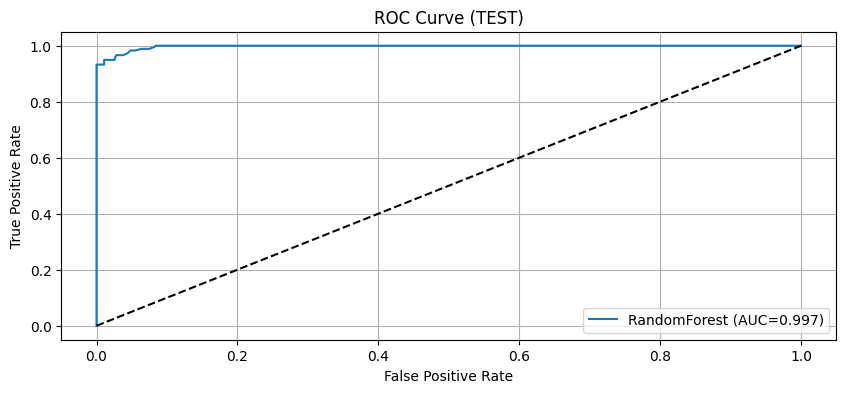

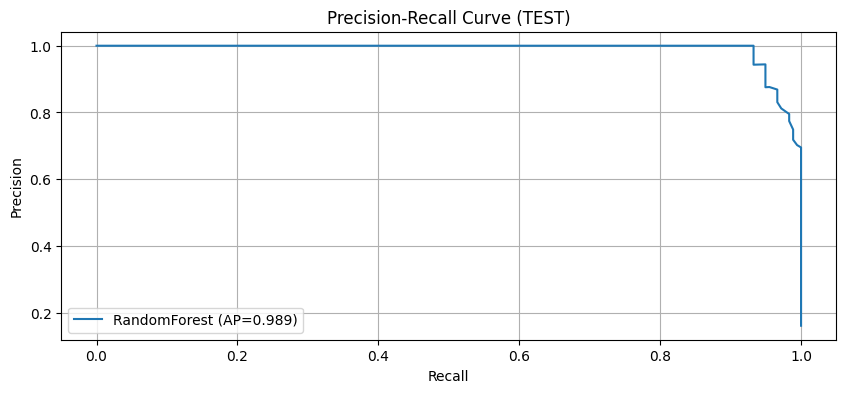

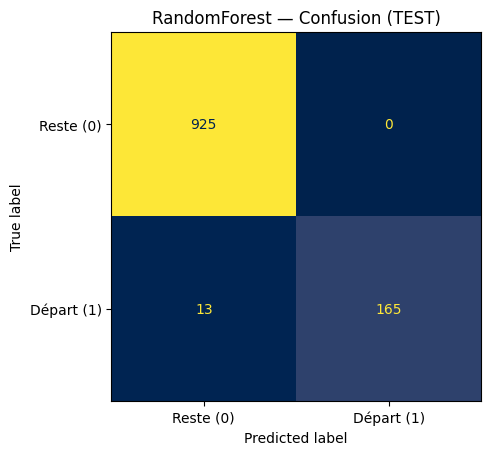

In [82]:

m_final = make_pipe(best_model_name, selected_models[best_model_name])
m_final.fit(X_train, y_train)

y_pred = m_final.predict(X_test)

print("Accuracy  :", round(accuracy_score(y_test, y_pred), 3))
print("Precision :", round(precision_score(y_test, y_pred, zero_division=0), 3))
print("Recall    :", round(recall_score(y_test, y_pred, zero_division=0), 3))
print("F1        :", round(f1_score(y_test, y_pred, zero_division=0), 3))

print("\nConfusion Matrix\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report\n", classification_report(y_test, y_pred, zero_division=0))

# Score pour ROC/PR : proba si dispo, sinon decision_function, sinon fallback
if hasattr(m_final, "predict_proba"):
    y_score = m_final.predict_proba(X_test)[:, 1]
elif hasattr(m_final, "decision_function"):
    y_score = m_final.decision_function(X_test)
else:
    y_score = y_pred.astype(float)

# ROC
fpr, tpr, _ = roc_curve(y_test, y_score)
area = roc_auc_score(y_test, y_score)

plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC={area:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (TEST)")
plt.legend()
plt.grid(True)
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.figure(figsize=(10, 4))
plt.plot(recall, precision, label=f"{best_model_name} (AP={ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (TEST)")
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix plot (TEST)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=["Reste (0)", "Départ (1)"]).plot(
    cmap=CMAP, values_format="d", colorbar=False
)
plt.title(f"{best_model_name} — Confusion (TEST)")
plt.show()


## 12) Temps d’entraînement & prédiction (pipelines, donc sans erreurs)

In [83]:
training_times = []
prediction_times = []

for name, model in selected_models.items():
    pipe = make_pipe(name, model)

    t0 = time.perf_counter()
    pipe.fit(X_train, y_train)
    training_times.append(time.perf_counter() - t0)

    t0 = time.perf_counter()
    _ = pipe.predict(X_test)
    prediction_times.append(time.perf_counter() - t0)

time_df = pd.DataFrame({
    "Model": list(selected_models.keys()),
    "Training Time (s)": training_times,
    "Prediction Time (s)": prediction_times
}).sort_values("Training Time (s)")

try:
    display(time_df)
except NameError:
    print(time_df.to_string(index=False))


,Model,Training Time (s),Prediction Time (s)
3,SVM,0.040950,0.008267
1,XGBoost,0.524255,0.014413
0,RandomForest,0.719999,0.090105
2,LogReg,1.419321,0.008099


# Conclusion

#  Annexes